Missing dependencies installations

In [1]:
!pip install tbats
!pip install --no-cache-dir tbats
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 855.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00


Import Required Libraries

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tbats import TBATS
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")


Load and Data Exploration

In [178]:
# Load dataset
df = pd.read_csv("PT_Train.csv")

# Rename columns for better readability
df.rename(columns={"Timestamp (GMT)": "Timestamp", "Lifetouch Heart Rate": "Heart_Rate"}, inplace=True)

# Convert Timestamp column to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Check for data types
print("\n Data types:", df.info())

print("\n Data shape:", df.shape)

print("\n Data description:", df.describe())

# Display first few rows
df.head()



Missing values:
 Heart_Rate                     0
Lifetouch Respiration Rate     0
Oximeter SpO2                 35
Oximeter Pulse                35
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 226 entries, 2015-08-17 15:09:00 to 2015-08-17 18:54:00
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Heart_Rate                  226 non-null    int64  
 1   Lifetouch Respiration Rate  226 non-null    int64  
 2   Oximeter SpO2               191 non-null    float64
 3   Oximeter Pulse              191 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 8.8 KB

 Data types: None

 Data shape: (226, 4)

 Data description:          Heart_Rate  Lifetouch Respiration Rate  Oximeter SpO2  Oximeter Pulse
count    226.000000                  226.000000     191.000000      191.000000
mean    2315.615044                 2219.216814      83.450262      126.335079
std  

,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0


Visualize Raw Data (Before Cleaning)

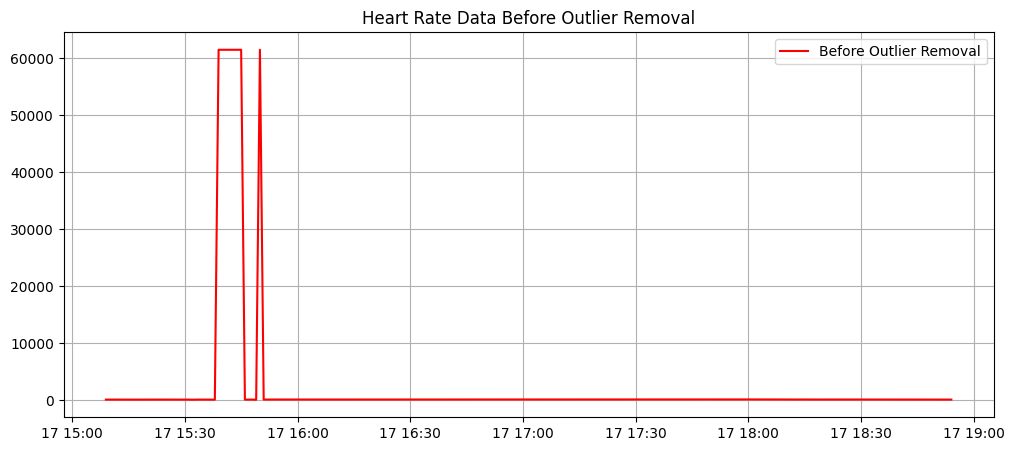

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Heart_Rate"], label="Before Outlier Removal", color="red")
plt.title("Heart Rate Data Before Outlier Removal")
plt.legend()
plt.grid(True)
plt.show()

Remove Outliers Using Z-score

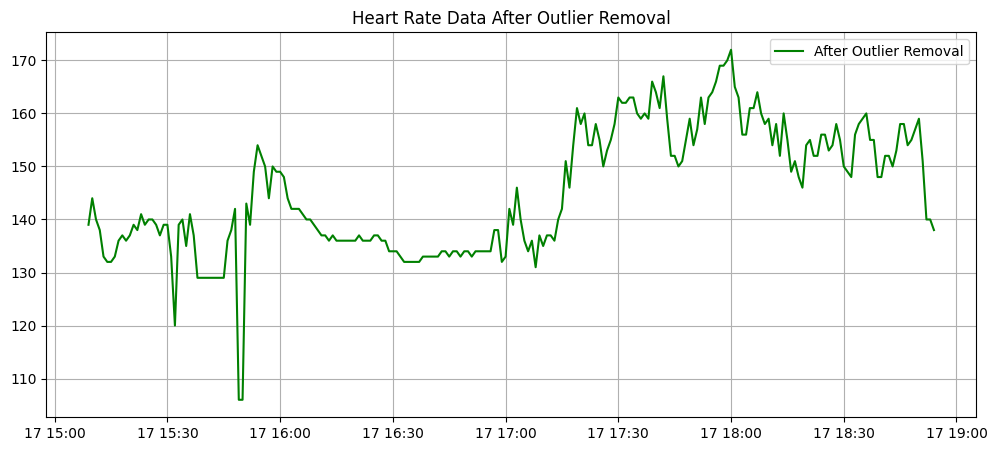

,Heart_Rate
count,226.000000
mean,145.163717
std,11.801496
min,106.000000
25%,136.000000
50%,142.000000
75%,155.000000
max,172.000000


In [179]:
# Compute Z-score
z_scores = (df["Heart_Rate"] - df["Heart_Rate"].mean()) / df["Heart_Rate"].std()

# Replace values with NaN if they exceed Z-score threshold of 3
df["Heart_Rate"] = df["Heart_Rate"].mask(np.abs(z_scores) > 3, np.nan)

# Fill missing values
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)

# Plot cleaned data
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Heart_Rate"], label="After Outlier Removal", color="green")
plt.title("Heart Rate Data After Outlier Removal")
plt.legend()
plt.grid(True)
plt.show()

df['Heart_Rate'].describe()

Check for Stationarity and Apply Box-Cox Transformation
if the data is stationary and apply transformations

ADF p-value before transformation: 0.002415527582011085
ADF p-value after Box-Cox: 0.002415527582011085


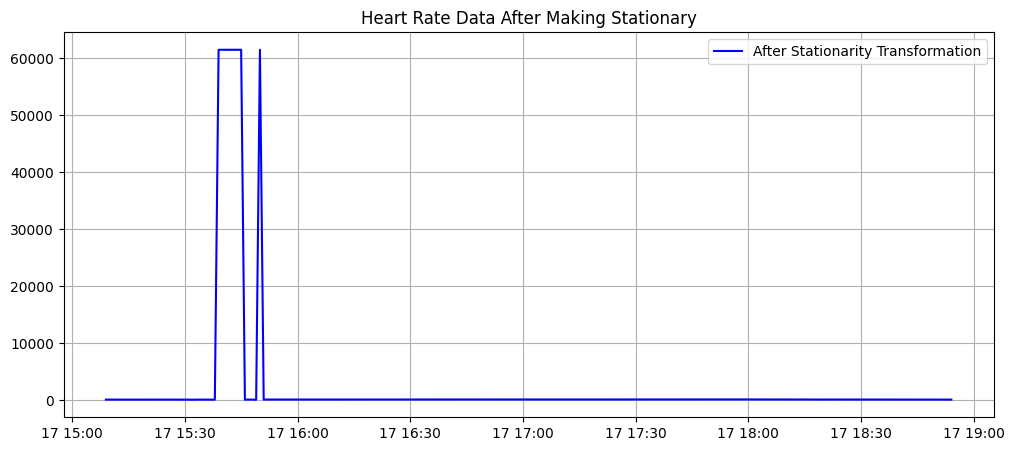

,Heart_Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
Timestamp,,,,
2015-08-17 15:09:00,139,41,NaN,NaN
2015-08-17 15:10:00,144,40,92.0,140.0
2015-08-17 15:11:00,140,42,89.0,144.0
2015-08-17 15:12:00,138,45,93.0,141.0
2015-08-17 15:13:00,133,42,94.0,134.0


In [163]:
# Run ADF test before transformation
result = adfuller(df["Heart_Rate"])
print("ADF p-value before transformation:", result[1])

# Apply Box-Cox Transformation if p-value > 0.05 (non-stationary)
if result[1] > 0.05:
    df["Heart_Rate"], lambda_boxcox = boxcox(df["Heart_Rate"])
    print("Applied Box-Cox Transformation")
else:
    lambda_boxcox = None

# Run ADF test again after Box-Cox
result = adfuller(df["Heart_Rate"])
print("ADF p-value after Box-Cox:", result[1])

# Apply Differencing if still non-stationary
if result[1] > 0.05:
    df["Heart_Rate"] = df["Heart_Rate"].diff().dropna()
    print("Applied Differencing")

# Visualize transformed data
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Heart_Rate"], label="After Stationarity Transformation", color="blue")
plt.title("Heart Rate Data After Making Stationary")
plt.legend()
plt.grid(True)
plt.show()

df.head()


Feature Engineering

In [159]:
# Feature Engineering
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["rolling_mean"] = df["Heart_Rate"].rolling(window=5).mean()
df["rolling_std"] = df["Heart_Rate"].rolling(window=5).std()

# FINAL MISSING VALUE HANDLING
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)
df.dropna(inplace=True)

# Remove Any Infinite Values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Final Print Check
print("\n Final Missing Values Check:\n", df.isnull().sum())


 Final Missing Values Check:
 Heart_Rate                    0
Lifetouch Respiration Rate    0
Oximeter SpO2                 0
Oximeter Pulse                0
hour                          0
day_of_week                   0
rolling_mean                  0
rolling_std                   0
dtype: int64


Train-Test Split

Split the dataset into training and testing sets.

In [180]:
train_size = len(df) - 20
train_df, test_df = df[:train_size], df[train_size:]

# Print sizes
print(f"Training set size: {len(train_df)}, Testing set size: {len(test_df)}")


Training set size: 206, Testing set size: 20


**Train Models**

Moving Average Model

In [181]:
moving_avg_forecast = train_df["Heart_Rate"].rolling(window=5).mean()
moving_avg_forecast.head(20)

,Heart_Rate
Timestamp,
2015-08-17 15:09:00,NaN
2015-08-17 15:10:00,NaN
2015-08-17 15:11:00,NaN
2015-08-17 15:12:00,NaN
2015-08-17 15:13:00,138.8
2015-08-17 15:14:00,137.4
2015-08-17 15:15:00,135.0
2015-08-17 15:16:00,133.6
2015-08-17 15:17:00,133.2


Holt-Winters Exponential Smoothing Model

In [182]:
exp_smoothing_model = ExponentialSmoothing(train_df["Heart_Rate"], trend="add", seasonal="add", seasonal_periods=12).fit()

ARIMA Model

In [183]:
auto_arima_model = auto_arima(train_df["Heart_Rate"], seasonal=False, trace=False, suppress_warnings=True)
arima_model = ARIMA(train_df["Heart_Rate"], order=auto_arima_model.order).fit()


SARIMA Model

In [184]:
auto_sarima_model = auto_arima(train_df["Heart_Rate"], seasonal=True, m=12, trace=False, suppress_warnings=True)
sarima_model = SARIMAX(train_df["Heart_Rate"], order=auto_sarima_model.order, seasonal_order=auto_sarima_model.seasonal_order).fit()

TBATS Model

In [185]:
tbats_model = TBATS(seasonal_periods=[12]).fit(train_df["Heart_Rate"])


**Model Predictions**

generate predictions from trained models.

Moving Average Model Prediction

In [153]:
moving_avg_pred = moving_avg_forecast[-20:]
# print(f'Top 5 prediction {moving_avg_pred.head(5)}')

mse = mean_squared_error(test_df["Heart_Rate"], moving_avg_pred)
mae = mean_absolute_error(test_df["Heart_Rate"], moving_avg_pred)
r2 = r2_score(test_df["Heart_Rate"], moving_avg_pred)
mape = np.mean(np.abs((test_df["Heart_Rate"] - moving_avg_pred) / test_df["Heart_Rate"])) * 100

print(f"Moving Average Model Evaluation Metrics - MSE: {mse}, MAE: {mae}, R2: {r2}, MAPE: {mape}")

Moving Average Model Evaluation Metrics - MSE: 30.163999999999966, MAE: 3.7999999999999985, R2: 0.25686129588568696, MAPE: nan


Holt-Winters Model Prediction

In [173]:
exp_smoothing_pred = exp_smoothing_model.forecast(steps=20)
exp_smoothing_pred.head(20)

mse = mean_squared_error(test_df["Heart_Rate"], exp_smoothing_pred)
mae = mean_absolute_error(test_df["Heart_Rate"], exp_smoothing_pred)
r2 = r2_score(test_df["Heart_Rate"], exp_smoothing_pred)
mape = np.mean(np.abs((test_df["Heart_Rate"] - exp_smoothing_pred) / test_df["Heart_Rate"])) * 100

print(f"Holt-Winters Model Evaluation Metrics - MSE: {mse}, MAE: {mae}, R2: {r2}, MAPE: {mape}")

Holt-Winters Model Evaluation Metrics - MSE: 26021931.654038657, MAE: 4120.51503703297, R2: -641091.1816713145, MAPE: 2671.4836383172524


ARIMA Model Prediction

In [174]:
arima_pred = arima_model.forecast(steps=20)
arima_pred.head(20)

mse = mean_squared_error(test_df["Heart_Rate"], arima_pred)
mae = mean_absolute_error(test_df["Heart_Rate"], arima_pred)
r2 = r2_score(test_df["Heart_Rate"], arima_pred)
mape = np.mean(np.abs((test_df["Heart_Rate"] - arima_pred) / test_df["Heart_Rate"])) * 100

print(f"ARIMA Model Evaluation Metrics - MSE: {mse}, MAE: {mae}, R2: {r2}, MAPE: {mape}")

ARIMA Model Evaluation Metrics - MSE: 3910390.241997283, MAE: 1909.2492520652625, R2: -96337.75934952656, MAPE: 1263.6792212249197


SARIMA Model Prediction

In [175]:
sarima_pred = sarima_model.forecast(steps=20)
sarima_pred.head(20)

mse = mean_squared_error(test_df["Heart_Rate"], sarima_pred)
mae = mean_absolute_error(test_df["Heart_Rate"], sarima_pred)
r2 = r2_score(test_df["Heart_Rate"], sarima_pred)
mape = np.mean(np.abs((test_df["Heart_Rate"] - sarima_pred) / test_df["Heart_Rate"])) * 100

print(f"SARIMA Model Evaluation Metrics - MSE: {mse}, MAE: {mae}, R2: {r2}, MAPE: {mape}")

SARIMA Model Evaluation Metrics - MSE: 20573.591871566958, MAE: 138.61808922697796, R2: -505.8635592896516, MAPE: 91.43815955383077


TBATS Model Prediction

In [176]:
tbats_pred = tbats_model.forecast(steps=20)

mse = mean_squared_error(test_df["Heart_Rate"], tbats_pred)
mae = mean_absolute_error(test_df["Heart_Rate"], tbats_pred)
r2 = r2_score(test_df["Heart_Rate"], tbats_pred)
mape = np.mean(np.abs((test_df["Heart_Rate"] - tbats_pred) / test_df["Heart_Rate"])) * 100

print(f"TBATS Model Evaluation Metrics - MSE: {mse}, MAE: {mae}, R2: {r2}, MAPE: {mape}")

TBATS Model Evaluation Metrics - MSE: 62.24344569167878, MAE: 7.0289755527909294, R2: -0.5334674967154172, MAPE: 4.578458171692336


Visualize Predictions

Actual vs Predicted Heart Rate Values.

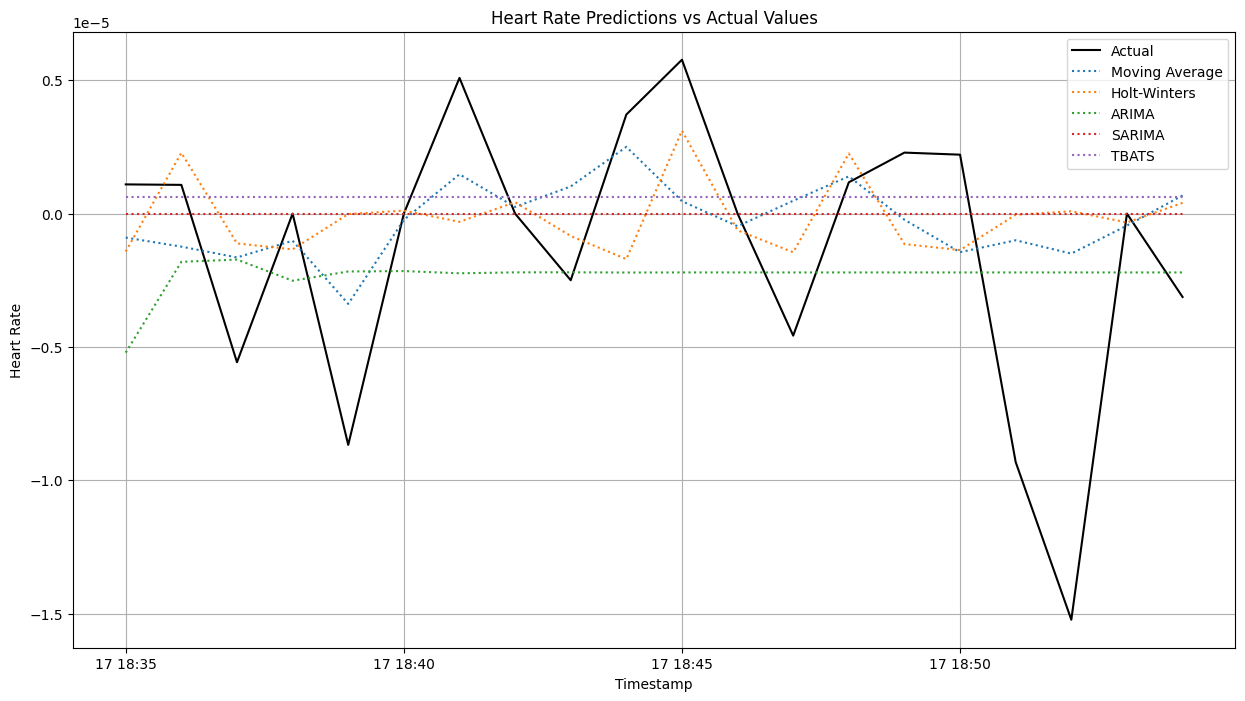

In [57]:
models = {
    "Moving Average": moving_avg_pred,
    "Holt-Winters": exp_smoothing_pred,
    "ARIMA": arima_pred,
    "SARIMA": sarima_pred,
    "TBATS": tbats_pred
}
plt.figure(figsize=(15, 8))
plt.plot(test_df.index, test_df["Heart_Rate"], label="Actual", color="black")

for name, forecast in models.items():
    plt.plot(test_df.index, forecast, linestyle="dotted", label=name)

plt.title("Heart Rate Predictions vs Actual Values")
plt.xlabel("Timestamp")
plt.ylabel("Heart Rate")
plt.legend()
plt.grid(True)
plt.show()


In [58]:
moving_avg_forecast.head(20)

,Heart_Rate
Timestamp,
2015-08-17 15:09:00,NaN
2015-08-17 15:10:00,NaN
2015-08-17 15:11:00,NaN
2015-08-17 15:12:00,NaN
2015-08-17 15:13:00,-5.014965e-07
2015-08-17 15:14:00,-2.348049e-06
2015-08-17 15:15:00,-3.838579e-06
2015-08-17 15:16:00,-2.301699e-06
2015-08-17 15:17:00,-6.504873e-07
